In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


import io, os, time, cv2
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib as mpl

%load_ext autoreload
%autoreload 2
%matplotlib inline

### Prepare image

In [2]:
class MalariaDataset(Dataset):
    def __init__(self, data, transform = None):
        super().__init__()
        self.data = data.values
        self.path = data.label
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_path, label = self.data[index]
        fname = os.path.basename(img_path)
        image = Image.open(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label, fname

In [3]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size



In [4]:
# load data
path = r"C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\test\crops"
matches = []
for root, dirnames, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('.png'):
#             print (filename)
            matches.append(os.path.join(root, filename))
print (len(matches))

class_name = {"U": 0, 'R': 1, 'T': 2, 'S': 3, 'G': 4}
df_test = pd.DataFrame(matches, columns = ["img_path"])

df_test.loc[:, "stage"] = df_test["img_path"].str.split("\\", expand = True)[9]
df_test.loc[:, "label"] = df_test["stage"].map(class_name)
# create a list of the values we want to assign for each condition

# create a new column and use np.select to assign values to it using our lists as arguments
df_test.head()

df_test = df_test.dropna()
df_test.groupby("label").count()

8739


,img_path,stage
label,,
0,8118,8118
1,239,239
2,186,186
3,150,150
4,46,46


In [40]:
print(df_test.groupby("stage").count())

       img_path  label
stage                 
G            46     46
R           239    239
S           150    150
T           186    186
U          8118   8118


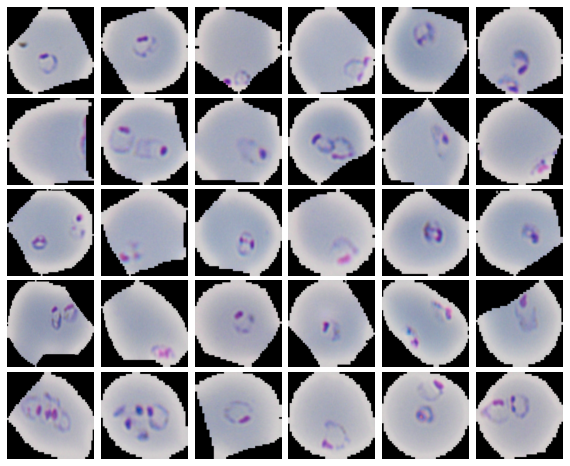

In [5]:
fig = plt.figure(figsize = (10,10))
gs1 = mpl.gridspec.GridSpec(6, 6)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

for idx, val in enumerate(df_test[df_test['label'] == 1]["img_path"][200:230]):
#     print (idx, val)
    ax = plt.subplot(gs1[idx])
    ax.axis("off")
    ax.set_aspect('equal')
    im = plt.imread(val)
    img_scaled = cv2.resize(im, (224, 224), interpolation = cv2.INTER_AREA)
    ax.imshow(img_scaled)

In [95]:
my_transforms = transforms.Compose([transforms.Resize((200, 200)),
                                    transforms.CenterCrop((128, 128)),
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        [0.485, 0.456, 0.406],
                                        [0.229, 0.224, 0.225])])
def transform_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)

In [96]:
batch_size = 256
test_dataset =  MalariaDataset(df_test[["img_path", "label"]], my_transforms)               
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False, num_workers=0)

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

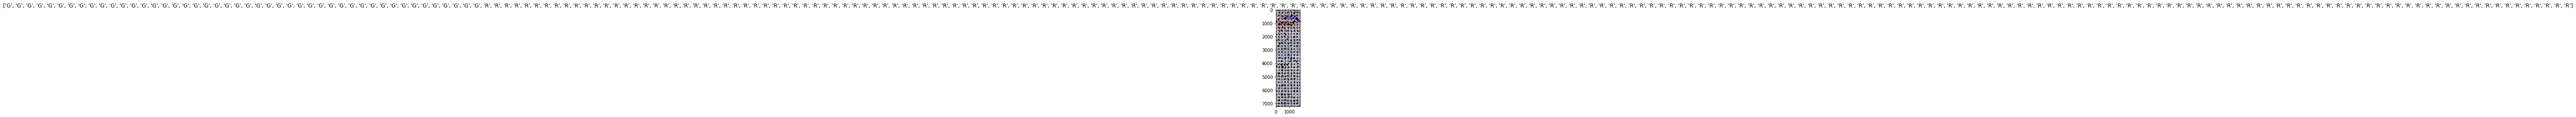

In [9]:
class_names = ["U", 'R', 'T', 'S', 'G']
inputs, classes, fnames = next(iter(test_loader))
# class_names = ["un", 'ring', 'troph', 'shiz']
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Load the model

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    outputs = model.forward(tensor)
    _, y_hat = outputs.max(1)
    return class_names[y_hat]

In [97]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 5

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 30

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_name)
print("Number of trainable params: " + str(count_parameters(model_ft)))
# add2log(str(summary(model_ft)))

resnet
Number of trainable params: 2565


In [98]:
# load model state dict
model_path = r"C:\Users\AChub_Lab\Desktop\my_project\st_app\malaria-detection-classification\nbs\resnet_model_5c_v4.pth"
model_ft.load_state_dict(torch.load(model_path))
model_ft.eval()
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [99]:
# test-the-model
ls_df = []
all_preds = []
test_labels = []
since = time.time()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels, fnames) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.append(predicted)
        test_labels.append(labels)
        
        tmp_df = pd.DataFrame(zip(fnames, predicted.cpu().numpy()))
        ls_df.append(tmp_df)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))
time_elapsed = time.time() - since
print('Inference complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
# Save 
# torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 99.3248655452569 %
Inference complete in 0m 53s


In [52]:
df_pred = pd.concat(ls_df)
df_pred.columns = ["fname", "pred"]
df_pred.head()

,fname,pred
0,3D7-11-DAY-120719-5_205.png,4
1,3D7-11-DAY-120719-6_146.png,4
2,3D7-14-DAY-150719-3_310.png,4
3,3D7-14-DAY-150719-4_188.png,4
4,3D7-4-DAY-050719-3_194.png,4


In [43]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns

In [100]:
y_true, y_pred = torch.cat(test_labels).cpu(), torch.cat(all_preds).cpu()

Text(0.5, 50.5, 'Predicted label')

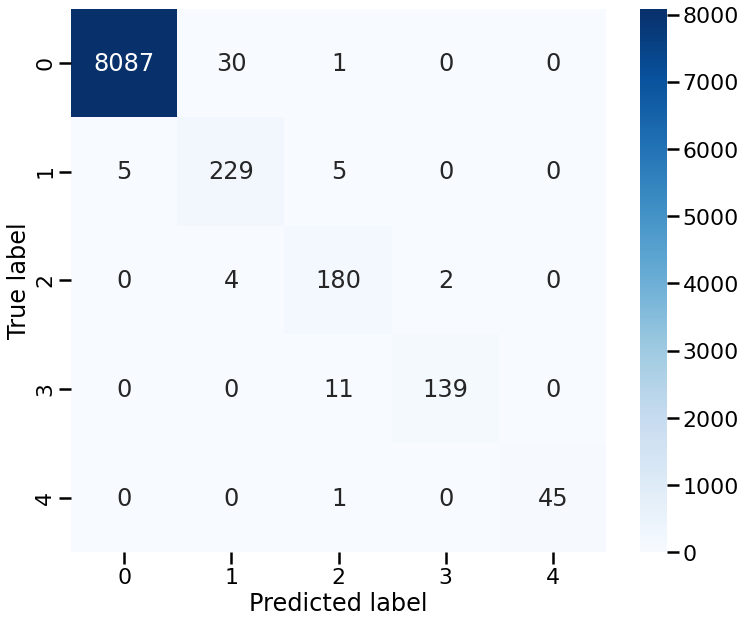

In [101]:
sns.set_context("poster")
f, ax = plt.subplots(figsize = (12,10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot = True, cmap = "Blues", fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [102]:
precision = precision_score(y_true, y_pred, labels = [1,2,3,4], average='micro')
print('precision: %.3f' % precision)
recall = recall_score(y_true, y_pred, labels = [1,2,3,4], average='micro')
print('recall: %.3f' % recall)
score = f1_score(y_true, y_pred, labels = [1,2,3,4], average='micro')
print('F-Measure: %.3f' % score)

precision: 0.917
recall: 0.955
F-Measure: 0.935


In [48]:
y_pred

tensor([4, 4, 4,  ..., 0, 0, 0])

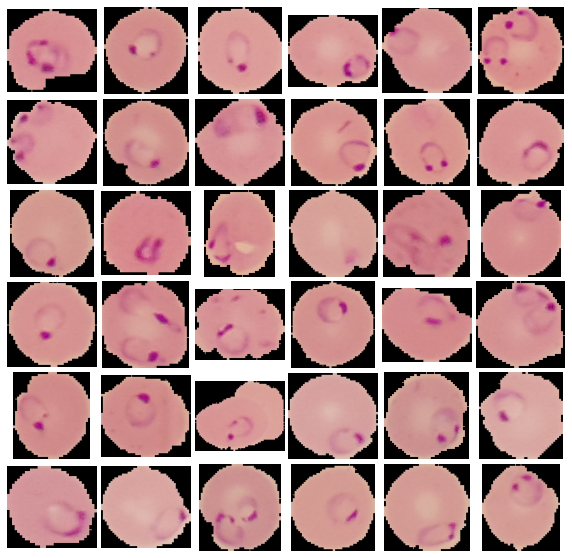

In [42]:
root_path = r"C:\Users\AChub_Lab\Desktop\my_project\cell_images\cell_images\Parasitized"
img_ls = df_pred[df_pred.pred == 2].fname.values

fig = plt.figure(figsize = (10,10))
gs1 = mpl.gridspec.GridSpec(6, 6)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 
start = 20
for idx, val in enumerate(img_ls[start*36:start*36+36]):
#     print (idx, val)
    ax = plt.subplot(gs1[idx])
    ax.axis("off")
    ax.set_aspect('equal')
    im = plt.imread(os.path.join(root_path, val))
#     img_scaled = cv2.resize(im, (224, 224), interpolation = cv2.INTER_AREA)
    ax.imshow(im)

In [118]:
img_ls

array(['C100P61ThinF_IMG_20150918_144104_cell_166.png',
       'C100P61ThinF_IMG_20150918_144348_cell_142.png',
       'C100P61ThinF_IMG_20150918_144823_cell_158.png', ...,
       'C99P60ThinF_IMG_20150918_142334_cell_4.png',
       'C99P60ThinF_IMG_20150918_142334_cell_6.png',
       'C99P60ThinF_IMG_20150918_142334_cell_9.png'], dtype=object)

### Compare to Malaria cell analyzer

In [92]:
# convert tiff -> jpg
import os
from PIL import Image

yourpath = r"C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\test\images"
for root, dirs, files in os.walk(yourpath, topdown=False):
    for name in files:
        print(os.path.join(root, name))
        if os.path.splitext(os.path.join(root, name))[1].lower() == ".tif":
            if os.path.isfile(os.path.splitext(os.path.join(root, name))[0] + ".jpg"):
                print ("A jpeg file already exists for %s" % name)
            # If a jpeg is *NOT* present, create one from the tiff.
            else:
                outfile = os.path.splitext(os.path.join(root, name))[0] + ".jpg"
                try:
                    im = Image.open(os.path.join(root, name))
                    print ("Generating jpeg for %s" % name)
                    im.thumbnail(im.size)
                    im.save(outfile, "JPEG", quality=100)
                except Exception as e:
                    print (e)

C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\test\images\Rings\.DS_Store
C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\test\images\Rings\T0R1_1.tif
Generating jpeg for T0R1_1.tif
C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\test\images\Rings\T0R1_2.tif
Generating jpeg for T0R1_2.tif
C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\test\images\Rings\T10R2_1.tif
Generating jpeg for T10R2_1.tif
C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\test\images\Rings\T10R2_2.tif
Generating jpeg for T10R2_2.tif
C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\test\images\Rings\T12R3_1.tif
Generating jpeg for T12R3_1.tif
C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\test\images\Rings\T12R3_2.tif
Generating jpeg for T12R3_2.tif
C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\test\images\Rings\T4R3_1.tif
Generating jpeg for T4R3_1.tif
C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\test\images\Rings\T6R2_1.tif
Generating jpeg for T6R2_1.tif
C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\test